<a href="https://colab.research.google.com/github/vidzshan/vidzshan/blob/main/bracemodule5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [2]:
import os
from google.colab import drive

MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks','Research')
drive.mount(MOUNTPOINT)

#Access the data
#path = os.path.join(DATADIR, 'data')

#save trained data results or modules
#model.save(os.path.join(DATADIR, 'model.h5'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here is the `requirements.txt` file with the packages you specified. You can use this file to install the dependencies for your project.

In [2]:
%%writefile requirements.txt
smplx
pyrender
trimesh
torch-geometric
essentia
mediapipe
numpy<2

Writing requirements.txt


In [ ]:
#pip install -r requirements.txt

In [3]:
import numpy as np
import os
import torch
import smplx

model_path = os.path.join(DATADIR, 'smplx_models','SMPLX_NEUTRAL_2020.npz')

# Load BRACE keypoint sample
keypoints_path = os.path.join(DATADIR, 'brace','manual_keypoints', '2011', '3rIk56dcBTM', 'img-001293.npz')
keypoints_data = np.load(keypoints_path)
keypoints = keypoints_data['coco_joints2d'][:, :2]  # Shape: [17, 2] for x, y coords

# Install SMPL-X dependencies
#!pip install smplx pyrender trimesh
#!git clone https://github.com/vchoutas/smplx /content/smplx
smpl_model = smplx.create(model_path=model_path, model_type='smplx', gender='neutral', use_pca=False, num_betas = 10, num_expression_coeffs=10).to('cuda')
print("SMPL-X loaded successfully!")
# Forward pass with correct tensor shapes
output = smpl_model(
    betas=torch.zeros(1, 10).to('cuda'),
    expression=torch.zeros(1, 10).to('cuda'),
    body_pose=torch.zeros(1, 21*3).to('cuda'),  # 21 joints, 3D rotation each (not 21*6)
    global_orient=torch.zeros(1, 3).to('cuda')   # Add global_orient [1, 3]
)
print(f"Output vertices shape: {output.vertices.shape}")  # Should be [1, 10475, 3]

SMPL-X loaded successfully!
Output vertices shape: torch.Size([1, 10475, 3])


In [4]:
#this cell is responsible for loading, preprocessing, and structuring
#the keypoint and audio data into a format suitable for training a
#Graph Convolutional Network (GCN) model to classify dance types.
import pandas as pd
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from pathlib import Path
import json

# Load segments.csv
segments = pd.read_csv(Path(DATADIR) / 'brace' / 'annotations' / 'segments.csv')
sequences = segments.head(1353)  #sequences

# Define COCO skeleton edges (17 joints)
edge_index = torch.tensor([
    [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
    [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
    [0,15], [0,16]  # Nose to eyes
], dtype=torch.long).t().contiguous()

# Prepare data
data_list = []
for _, row in sequences.iterrows():
    keypoints_file = Path(DATADIR) / 'brace' / 'dataset' / str(row['year']) / row['video_id'] / f"{row['video_id']}_{row['start_frame']}-{row['end_frame']}_{row['dance_type']}.json.json"
    with open(keypoints_file, 'r') as f:
        keypoints_dict = json.load(f)
    keypoints_array = np.array([v['keypoints'] for v in keypoints_dict.values()])[:, :, :2]  # [frames, 17, 2]
    box = list(keypoints_dict.values())[0]['box']  # [x, y, w, h, score]
    keypoints_norm = (keypoints_array - [box[0], box[1]]) / [box[2], box[3]]  # Normalize

    # Compute velocity
    velocity = np.diff(keypoints_norm, axis=0, prepend=keypoints_norm[:1])  # [frames, 17, 2]

    # Load audio features
    audio_file = Path(DATADIR) / 'brace' / 'audio_features' / str(row['year']) / row['video_id'] / f"{row['video_id']}.{row['seq_idx']}.npz"
    if audio_file.exists():
        audio_data = np.load(audio_file)
        onset_beat = audio_data['onset_beat'].flatten()  # Ensure 1D array
        if len(onset_beat) > 1:  # Ensure enough points for interpolation
            onset_beat = np.interp(
                np.arange(len(keypoints_norm)),
                np.linspace(0, len(onset_beat)-1, len(onset_beat)),
                onset_beat
            )  # Align to keypoint frames
            onset_beat = onset_beat[:, np.newaxis, np.newaxis]  # [frames, 1, 1]
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2), onset_beat.reshape(-1, 1)], axis=1)  # [frames, 69]
        else:
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]
    else:
        x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(row['dance_type_id'], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

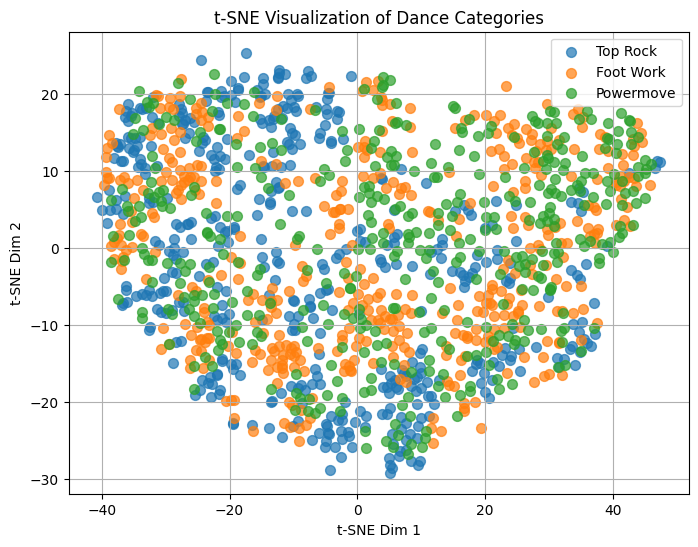

In [10]:
import numpy as np
n_frames = 50000  # choose a number (e.g., minimum sequence length in your data)

X = []
y = []
for data in data_list:
    x = data.x.cpu().numpy()              # shape: [T, J*C]
    T = x.shape[0]
    # Truncate or pad
    if T > n_frames:
        x_new = x[:n_frames]
    else:
        pad_width = ((0, n_frames-T), (0,0))  # pad T axis
        x_new = np.pad(x, pad_width, mode='constant')
    X.append(x_new.flatten())
    y.append(int(data.y.item()))

X = np.vstack(X)
y = np.array(y)
# Assuming your label mapping is:
idx_to_label = {0: "Top Rock", 1: "Foot Work", 2: "Powermove"}
labels = [idx_to_label[idx] for idx in y]

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for category in np.unique(y):
    idx = y == category
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=idx_to_label[category], alpha=0.7, s=50)

plt.title("t-SNE Visualization of Dance Categories")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
X_embedded = tsne.fit_transform(X)
print(X_embedded[:5])


[[ 15.343205    4.872363 ]
 [-25.12586    10.763467 ]
 [  0.9759336 -13.500314 ]
 [-37.020786    0.4293447]
 [-17.73819    22.293125 ]]


In [17]:
print(sequences.columns)
print(sequences.head(1353))


Index(['video_id', 'seq_idx', 'start_frame', 'end_frame', 'dance_type',
       'dance_type_id', 'dancer', 'dancer_id', 'year', 'uid'],
      dtype='object')
         video_id  seq_idx  start_frame  end_frame dance_type  dance_type_id  \
0     3rIk56dcBTM        0          851       1221    toprock              0   
1     3rIk56dcBTM        0         1234       1330  powermove              1   
2     3rIk56dcBTM        0         1348       1555   footwork              2   
3     3rIk56dcBTM        0         1571       1645  powermove              1   
4     3rIk56dcBTM        1         1751       2085    toprock              0   
...           ...      ...          ...        ...        ...            ...   
1347  zvWiTWT3T2M        5         4198       4270    toprock              0   
1348  zvWiTWT3T2M        5         4281       4391  powermove              1   
1349  zvWiTWT3T2M        5         4407       4563   footwork              2   
1350  zvWiTWT3T2M        5         4576    

Opening move frequencies (first sequence of each dancer in each video):
dance_type
toprock      76
powermove     3
footwork      2
Name: count, dtype: int64


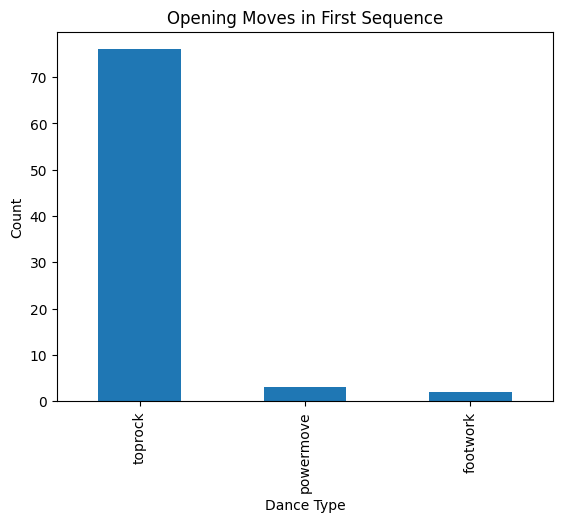

In [20]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Sort for safety
sequences = sequences.sort_values(['dancer_id', 'video_id', 'seq_idx', 'start_frame'])

# Get the first segment of every sequence for every dancer in every video (battle)
first_segments = sequences.groupby(['dancer_id', 'video_id', 'seq_idx']).first().reset_index()

# For each dancer & video (battle), get the opening move of their FIRST sequence (seq_idx == 0)
first_sequences = first_segments[first_segments['seq_idx'] == 0]

opening_move_counts = first_sequences['dance_type'].value_counts()
print("Opening move frequencies (first sequence of each dancer in each video):")
print(opening_move_counts)

# Plot
opening_move_counts.plot(kind='bar')
plt.title("Opening Moves in First Sequence")
plt.xlabel("Dance Type")
plt.ylabel("Count")
plt.show()


In [21]:
# For each sequence, get the progression of labels with repeats removed
def get_pattern(df):
    return tuple(df['dance_type'].drop_duplicates())

patterns = (sequences
    .sort_values(['dancer_id', 'video_id', 'seq_idx', 'start_frame'])
    .groupby(['dancer_id', 'video_id', 'seq_idx'])
    .apply(get_pattern)
)

pattern_counts = patterns.value_counts()
print("Most common label patterns per sequence:")
print(pattern_counts.head(10))


Most common label patterns per sequence:
(toprock, powermove, footwork)    172
(toprock, footwork)                70
(toprock, powermove)               69
(toprock, footwork, powermove)     60
(powermove,)                       28
(footwork,)                        20
(powermove, footwork)              19
(powermove, toprock, footwork)     11
(footwork, powermove)               5
(powermove, toprock)                4
Name: count, dtype: int64


/tmp/ipython-input-4020490087.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_pattern)


dance_type   footwork   powermove    toprock
seq_idx                                     
0           31.899668   38.789785  29.310548
1           36.642499   36.827307  26.530193
2           39.536389   38.764904  21.698707
3           38.921984   38.141062  22.936953
4           44.700659   27.763228  27.536113
5           42.965264   32.367224  24.667512
6            0.000000  100.000000   0.000000
7            0.000000  100.000000   0.000000


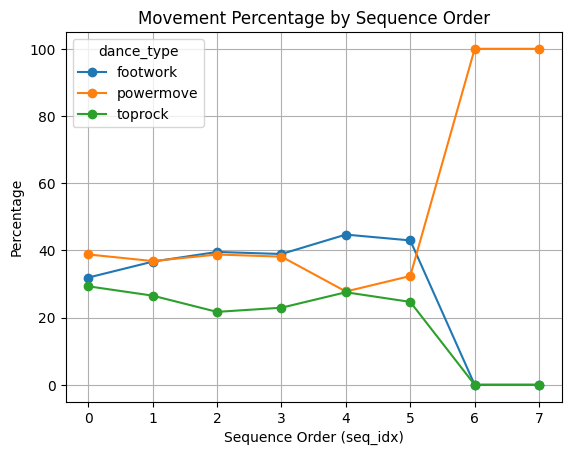

In [26]:
# For each sequence (grouped by seq_idx), calculate % of each dance_type

sequences['length'] = sequences['end_frame'] - sequences['start_frame'] + 1

# Calculate total length for each sequence
total_length_by_seq = sequences.groupby('seq_idx')['length'].sum()

# Calculate percentage of each dance_type within each sequence
percent_by_order = (sequences
    .groupby(['seq_idx', 'dance_type'])['length'].sum()
    .unstack(fill_value=0)  # Unstack first
    .div(total_length_by_seq, axis=0) * 100 # Then divide, specify axis=0
)

print(percent_by_order)

# Plot
percent_by_order.plot(marker='o')
plt.title('Movement Percentage by Sequence Order')
plt.xlabel('Sequence Order (seq_idx)')
plt.ylabel('Percentage')
plt.grid(True)
plt.show()

Global movement percentages:
dance_type
footwork     38.490695
powermove    35.934632
toprock      25.574673
Name: length, dtype: float64


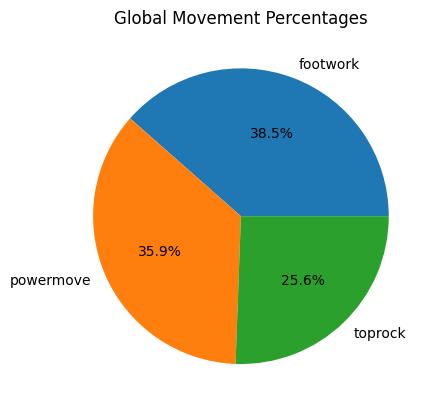

In [28]:
global_percents = sequences.groupby('dance_type')['length'].sum()
global_percents = 100 * global_percents / global_percents.sum()
print("Global movement percentages:")
print(global_percents)

# Pie chart
global_percents.plot(kind='pie', autopct='%.1f%%', title='Global Movement Percentages')
plt.ylabel('')
plt.show()


In [38]:
pattern_labels = {'toprock': 0, 'footwork': 1, 'powermove': 2}
max_segments = sequences.groupby(['video_id', 'seq_idx']).size().max()

def encode_pattern(pattern):
    vec = [pattern_labels.get(x, -1) for x in pattern]
    if len(vec) < max_segments:
        vec += [-1] * (max_segments - len(vec))
    return vec[:max_segments]

agg_df = (
    sequences.groupby(['video_id', 'seq_idx'])
    .agg({
        'length': ['sum', 'mean', 'std'],
        'dance_type': lambda x: list(x),
        'dancer_id': 'first'
    })
    .reset_index()
)
agg_df.columns = ['video_id', 'seq_idx', 'length_sum', 'length_mean', 'length_std', 'dance_types', 'dancer_id']
agg_df['pattern_vec'] = agg_df['dance_types'].apply(encode_pattern)


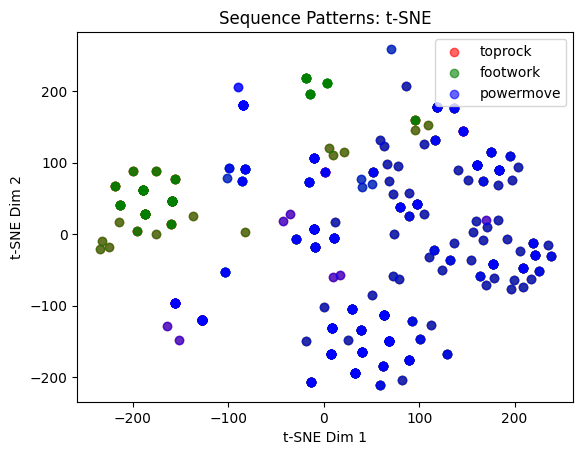

In [39]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_patterns = np.stack(agg_df['pattern_vec'].values)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_patterns)

colors = ['red', 'green', 'blue']
for i, dance_type in enumerate(['toprock', 'footwork', 'powermove']):
    idx = [j for j, pat in enumerate(agg_df['dance_types']) if dance_type in pat]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=dance_type, color=colors[i], alpha=0.6)
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.title('Sequence Patterns: t-SNE')
plt.legend()
plt.show()


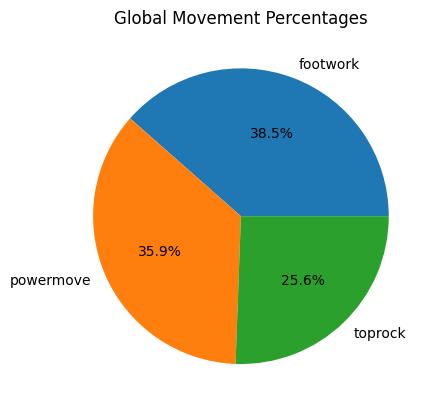

In [40]:
global_percents = sequences.groupby('dance_type')['length'].sum()
global_percents = 100 * global_percents / global_percents.sum()
global_percents.plot(kind='pie', labels=global_percents.index, autopct='%.1f%%')
plt.title('Global Movement Percentages')
plt.ylabel('')
plt.show()


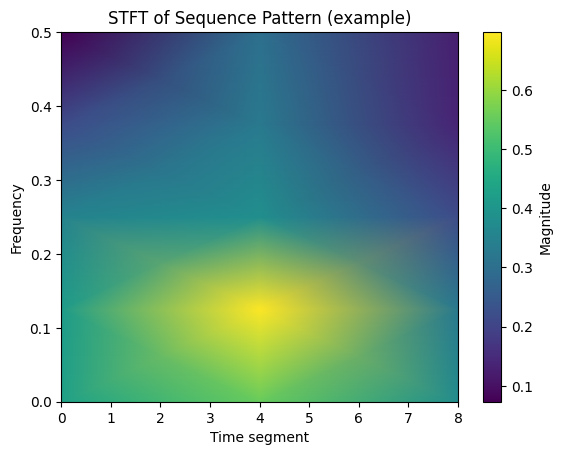

In [41]:
from scipy.signal import stft

# Example: analyze frequency content of sequence pattern (first item)
pattern_example = X_patterns[0]
f, t, Zxx = stft(pattern_example, nperseg=8)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT of Sequence Pattern (example)')
plt.ylabel('Frequency')
plt.xlabel('Time segment')
plt.colorbar(label='Magnitude')
plt.show()


In [ ]:
# patterns described in your “double helix” algorithm from BRACE-style segment data.
# This will let you calculate “motion”, “stillness”, and “interference” features from your annotated dance segments and visualize them.

# Assumptions & Setup
# You're using the pandas DataFrame sequences with columns:

# start_frame, end_frame — segment start/end

# dance_type — movement label ("toprock", "footwork", "powermove")

# You can define x(t) as either movement intensity, segment duration, or a custom metric per segment.

# For demonstration, we’ll use segment length for x(t) and set a manual example for r(t).

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Ensure length column exists
sequences['length'] = sequences['end_frame'] - sequences['start_frame'] + 1

# For the demo, set responsibility r(t) as a constant (e.g., 1 for all) or make it vary by 'dance_type'
resp_map = {"toprock": 0.7, "footwork": 0.5, "powermove": 1.0}
sequences['responsibility'] = sequences['dance_type'].map(resp_map)

# For a given dancer & video, build time-series vectors
def build_vectors(df):
    x_t = df['length'].values                # The observed signal: segment length
    r_t = df['responsibility'].values        # The responsibility vector
    y_t = r_t * x_t                          # Weighted signal
    return x_t, r_t, y_t

# Example: select one dancer and one video sequence
dancer_id = sequences['dancer_id'].iloc[0]
video_id = sequences['video_id'].iloc[0]
seq_df = sequences[(sequences['dancer_id'] == dancer_id) & (sequences['video_id'] == video_id)]

x_t, r_t, y_t = build_vectors(seq_df)


In [43]:
# Compute FFT (Discrete Fourier Transform)
N = len(x_t)
yf = fft(y_t)
xf = fftfreq(N, 1)  # "1" here means frame steps, adjust as needed for real time

# Power spectrum
power = np.abs(yf)**2

# Low and high frequency powers (example: split at 1/4 of the max frequency)
split = N // 4 if N >= 4 else 1
P_low = np.sum(power[:split])
P_high = np.sum(power[split:])

# Metrics
stillness = P_low / (P_low + P_high)
motion = P_high / (P_low + P_high)
print(f"Stillness: {stillness:.3f} | Motion: {motion:.3f}")


Stillness: 0.903 | Motion: 0.097


In [44]:
# Interference - correlation between low and high frequencies
interference = np.corrcoef(power[:split], power[split:split*2])[0, 1] if N >= 8 else 0
print(f"Interference (correlation): {interference:.3f}")


Interference (correlation): -1.000


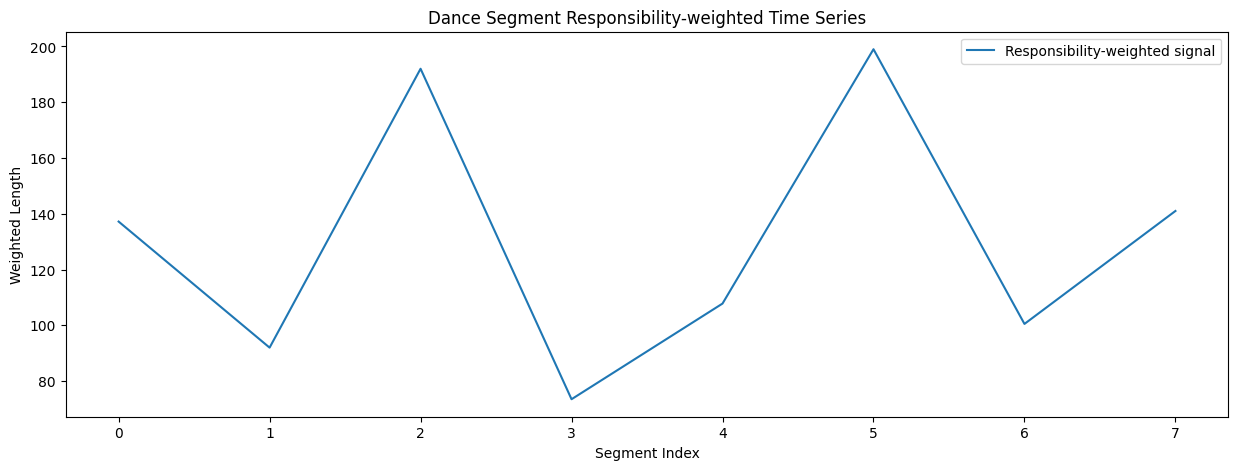

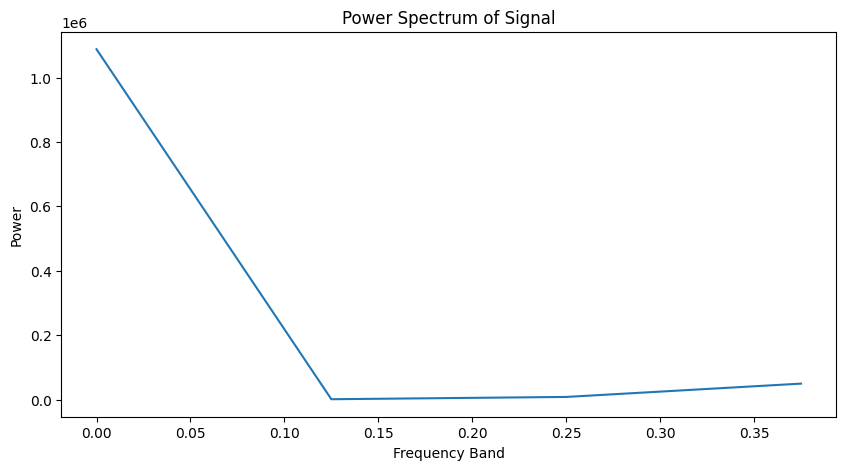

In [45]:
#Pattern Detection
# Use your metrics:
# High “motion” → mark as energetic segments
# High “stillness” → mark as calm/sustained segments
# High “interference” → possible stops/transitions
# E.g., summarize these for all dancers/segments:

plt.figure(figsize=(15,5))
plt.plot(y_t, label='Responsibility-weighted signal')
plt.title("Dance Segment Responsibility-weighted Time Series")
plt.xlabel("Segment Index")
plt.ylabel("Weighted Length")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(xf[:N//2], power[:N//2])
plt.title("Power Spectrum of Signal")
plt.xlabel("Frequency Band")
plt.ylabel("Power")
plt.show()


In [46]:
metrics = []
for (_dancer, _video), group in sequences.groupby(['dancer_id', 'video_id']):
    x_t, r_t, y_t = build_vectors(group)
    N = len(x_t)
    yf = fft(y_t)
    power = np.abs(yf)**2
    split = N // 4 if N >= 4 else 1
    P_low = np.sum(power[:split])
    P_high = np.sum(power[split:])
    stillness = P_low / (P_low + P_high)
    motion = P_high / (P_low + P_high)
    interference = np.corrcoef(power[:split], power[split:split*2])[0, 1] if N >= 8 else 0
    metrics.append({"dancer_id": _dancer, "video_id": _video,
                    "motion": motion, "stillness": stillness,
                    "interference": interference})

metrics_df = pd.DataFrame(metrics)
print(metrics_df.head())


   dancer_id     video_id    motion  stillness  interference
0          0  60EX6Tx_GvY  0.097167   0.902833          -1.0
1          0  9Nb7nQmm3Dc  0.348893   0.651107           0.0
2          0  IzgPV9TpX64  0.156856   0.843144           1.0
3          0  JNHbKAR2YvU  0.536935   0.463065          -1.0
4          0  f4PNzVPs5aY  0.144221   0.855779           1.0


In [ ]:
# You can adapt the weighting, frequency bands, or signal input to fit your features and segments.
# If you want to label patterns directly (“aggressive,” “still,” “high interference”), set thresholds and classify based on these results.
# Let me know if you’d like segment-wise visualization, or exactly “when” in the sequence these patterns occur!

In [29]:
#standard training loop for a PyTorch model, including forward and backward
#passes, optimizer steps, and periodic evaluation on a validation set.

# GCN model
class GCN(torch.nn.Module): #The base class for all neural network model
    def __init__(self):
        super(GCN, self).__init__()
        #First graph convolutional layer
        self.conv1 = GCNConv(69, 64)  # 34 (keypoints) + 34 (velocity) + 1 (onset_beat)
        #Second graph convolutional layer
        self.conv2 = GCNConv(64, 3)   # 3 classes

    def forward(self, data):#data flows through the network
        x, edge_index, batch = data.x, data.edge_index, data.batch  # Add batch for batched graphs
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Pool per graph in batch using global_mean_pool
        from torch_geometric.nn import global_mean_pool
        x = global_mean_pool(x, batch)  # Shape: [batch_size, 3]
        return x

# Train
model = GCN().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#Adam optimizer,
#lr: learning rate
criterion = torch.nn.CrossEntropyLoss()#Loss function
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)  # 80% train
val_loader = DataLoader(data_list[24:], batch_size=4)  # 20% val, validation data

#set the model to training mode
model.train()
for epoch in range(5):
    for data in loader:
        data = data.to('cuda')
        optimizer.zero_grad()
        out = model(data)  # Shape: [batch_size, 3] (e.g., [4, 3])
        loss = criterion(out, data.y)  # data.y is [batch_size] (e.g., [4])
        loss.backward()
        #every time your training loop runs a batch,
        #backpropagation occurs through loss.backward().
        #No manual gradient code is needed; PyTorch
        #auto-differentiation handles it all for you!
        optimizer.step()
    # Validate
    model.eval()
    correct = 0
    total = 0
    for data in val_loader:
        data = data.to('cuda')
        out = model(data)
        pred = out.argmax(dim=1)  # Predict per batch
        correct += (pred == data.y).sum().item()
        total += len(data.y)
    print(f"Epoch {epoch+1}, Val Accuracy: {correct/total:.2f}")

/tmp/ipython-input-2222284576.py:27: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)  # 80% train
/tmp/ipython-input-2222284576.py:28: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(data_list[24:], batch_size=4)  # 20% val, validation data


Epoch 1, Val Accuracy: 0.62
Epoch 2, Val Accuracy: 0.59
Epoch 3, Val Accuracy: 0.60
Epoch 4, Val Accuracy: 0.62
Epoch 5, Val Accuracy: 0.58


In [30]:
# Improved GCN model with dropout regularization
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ImprovedGCN(torch.nn.Module): # PyTorch neural network model.
    def __init__(self, dropout=0.3): #Dropout is a regularization technique that helps prevent overfitting.
        super(ImprovedGCN, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(69, 64) #input feature dimension of 69 (which likely corresponds to keypoint coordinates, velocity, and audio features) and outputs 64 features.
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index) #The node features passed through the 1st GCN layer
        x = F.relu(x) #Apply REUL function to the outpu of the 1st GCN layer
        x = F.dropout(x, p=self.dropout, training=self.training) #Apply dropout
        x = self.conv2(x, edge_index) #The output is passed through the 2nd GCN layer
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)#Ensure the dropout is only activate during training
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch) #This pools the features for each graph in the batch by taking the mean.
        #This results in a single feature vector per graph, which can then be used for classification
        return x #Return the pooled features

print("Improved GCN model with dropout=0.3 defined!")

Improved GCN model with dropout=0.3 defined!


In [31]:
# Data augmentation function for keypoints
import torch

def augment_keypoints(kpts): #kpts is a pytorch tensor containing keypoint data
    #apply augmentation to keypoint coordinates in computer vision tasks, such as pose estimation or object localization.
    """Add random jitter to keypoints for data augmentation"""
    return kpts + torch.randn_like(kpts) * 0.05

print("Data augmentation function defined!")
print("Augmentation: Random keypoint jitter with std=0.05")

Data augmentation function defined!
Augmentation: Random keypoint jitter with std=0.05


Set up the training configuration for the improvedGCN model

In [32]:
# Training loop with L2 weight decay, learning rate scheduler, early stopping
# Steps
# 1. Optimzer with regularization
# 2. A learning rate schedular
# 3. The loss function
# 4. Data loaders
import torch
import numpy as np
from torch_geometric.data import DataLoader

# Initialize improved model
model_improved = ImprovedGCN(dropout=0.3).to('cuda')

# L2 weight decay (1e-4) in optimizer
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.01, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
# Loss function, commany used on classification tasks
criterion = torch.nn.CrossEntropyLoss()

# Data loaders with augmentation
# Data loader for the training data
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)
# Data loader for the training data
val_loader = DataLoader(data_list[24:], batch_size=4)

print("Training configuration:")
print(f"  Model: ImprovedGCN with dropout=0.3")
print(f"  Optimizer: Adam with lr=0.01, weight_decay=1e-4")
print(f"  Scheduler: ReduceLROnPlateau(patience=2, factor=0.5)")
print(f"  Early stopping: patience=3 epochs")
print(f"  Training epochs: 10")
print(f"  Data augmentation: keypoint jitter (std=0.05)\n")

Training configuration:
  Model: ImprovedGCN with dropout=0.3
  Optimizer: Adam with lr=0.01, weight_decay=1e-4
  Scheduler: ReduceLROnPlateau(patience=2, factor=0.5)
  Early stopping: patience=3 epochs
  Training epochs: 10
  Data augmentation: keypoint jitter (std=0.05)



/tmp/ipython-input-1804298187.py:24: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)
/tmp/ipython-input-1804298187.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(data_list[24:], batch_size=4)


In [33]:
# Main training loop with all improvements
import numpy as np

# Training metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
loss_variances = []

# Early stopping variables
best_val_acc = 0.0
patience_counter = 0
patience = 3

print("Starting training with 10 epochs...\n")

for epoch in range(10):
    # Training phase
    model_improved.train()
    epoch_train_losses = []
    correct_train = 0
    total_train = 0

    for data in loader:
        data = data.to('cuda')
        # Apply data augmentation
        data.x = augment_keypoints(data.x)

        optimizer.zero_grad()
        out = model_improved(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())
        pred = out.argmax(dim=1)
        correct_train += (pred == data.y).sum().item()
        total_train += len(data.y)

    avg_train_loss = np.mean(epoch_train_losses)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model_improved.eval()
    epoch_val_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            data = data.to('cuda')
            out = model_improved(data)
            loss = criterion(out, data.y)
            epoch_val_losses.append(loss.item())
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += len(data.y)

    avg_val_loss = np.mean(epoch_val_losses)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Calculate loss variance
    loss_variance = np.var(epoch_train_losses)
    loss_variances.append(loss_variance)

    # Update learning rate scheduler
    scheduler.step(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/10:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Loss Variance: {loss_variance:.4f} {'(✓ < 0.2)' if loss_variance < 0.2 else '(✗ >= 0.2)'}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        print(f"  ✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience})")

    print()

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation accuracy: {best_val_acc:.4f}\n")
        break

print("Training completed!")
print(f"Final best validation accuracy: {best_val_acc:.4f}")

Starting training with 10 epochs...

Epoch 1/10:
  Train Loss: 1.2206, Train Acc: 0.3750
  Val Loss: 1.1653, Val Acc: 0.3780
  Loss Variance: 0.1011 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.3780

Epoch 2/10:
  Train Loss: 0.8886, Train Acc: 0.5833
  Val Loss: 1.1530, Val Acc: 0.4962
  Loss Variance: 0.0596 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.4962

Epoch 3/10:
  Train Loss: 0.8438, Train Acc: 0.6667
  Val Loss: 1.2887, Val Acc: 0.4202
  Loss Variance: 0.0424 (✓ < 0.2)
  Current LR: 0.010000
  No improvement (1/3)

Epoch 4/10:
  Train Loss: 0.7060, Train Acc: 0.6667
  Val Loss: 1.2620, Val Acc: 0.5038
  Loss Variance: 0.0921 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.5038

Epoch 5/10:
  Train Loss: 0.6482, Train Acc: 0.7083
  Val Loss: 1.1718, Val Acc: 0.5248
  Loss Variance: 0.1114 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.5248

Epoch 6/10:
  Train Loss: 0.6487, Train Acc: 0

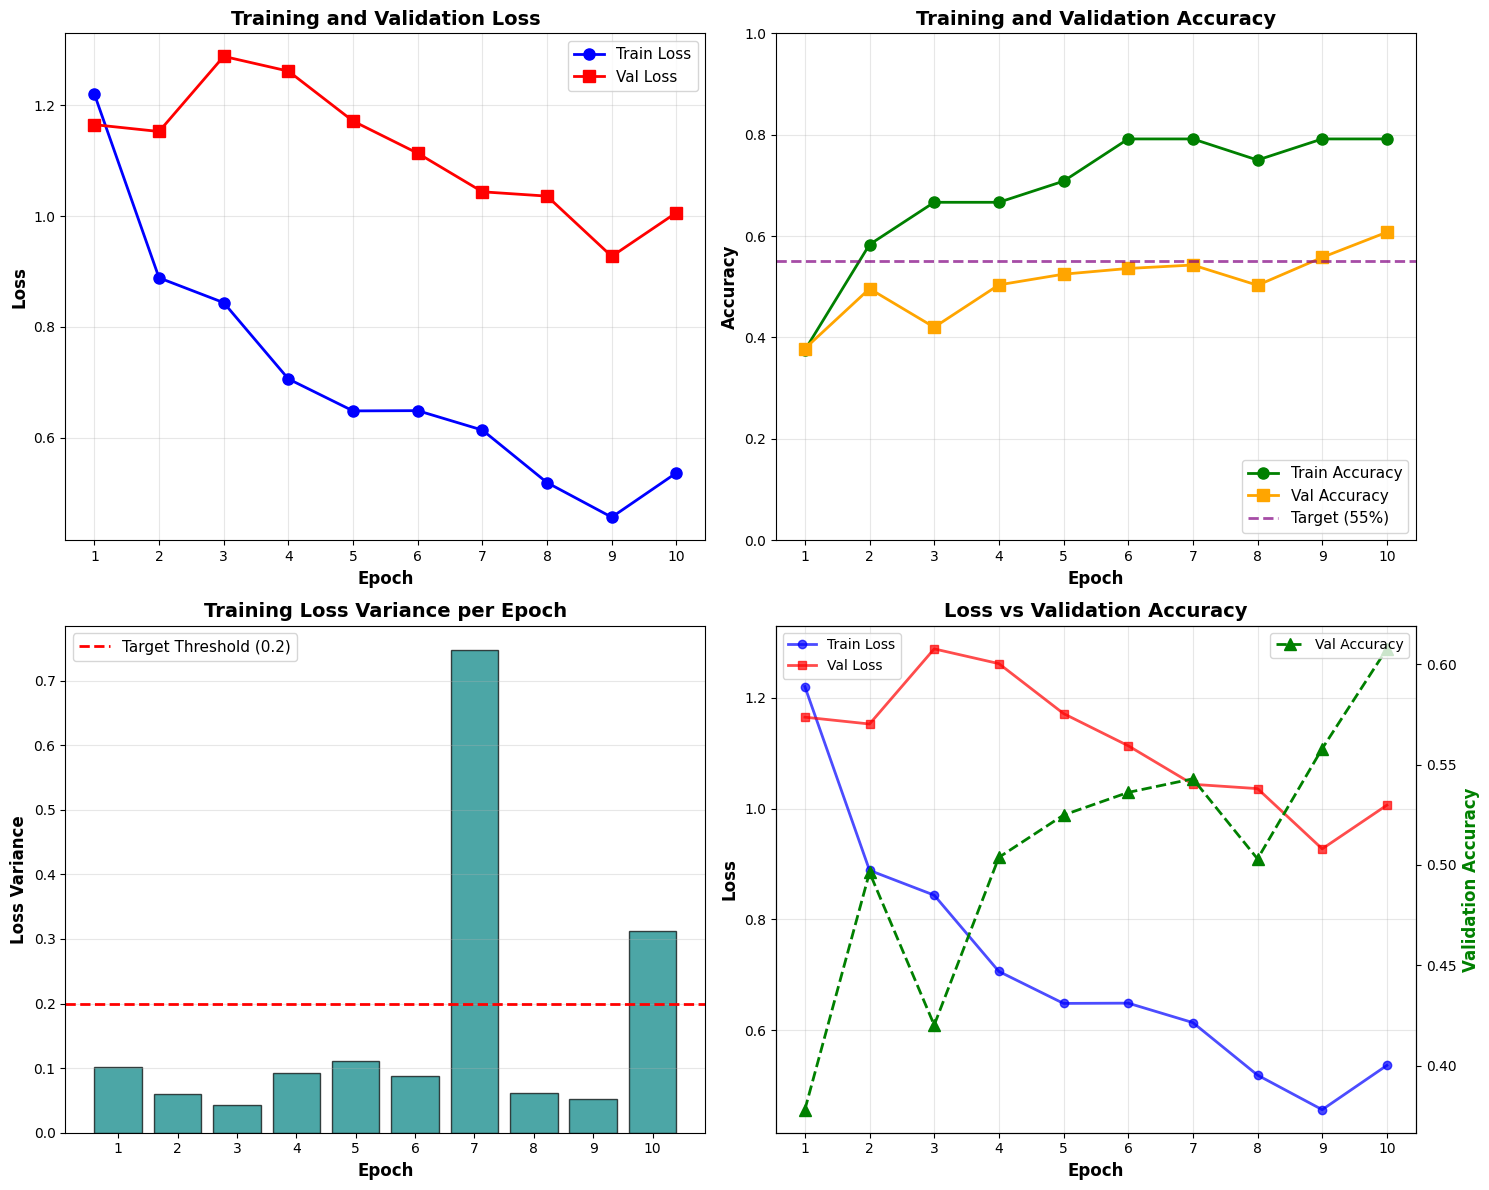


TRAINING SUMMARY
Total Epochs Run: 10
Best Validation Accuracy: 0.6077 (Epoch 10)
Final Train Loss: 0.5363
Final Val Loss: 1.0064
Final Train Accuracy: 0.7917
Final Val Accuracy: 0.6077

Loss Variance Statistics:
  Mean: 0.1668
  Min: 0.0424
  Max: 0.7473
  Epochs with variance < 0.2: 8/10


In [34]:
# Comprehensive plotting of training results
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
ax1 = axes[0, 0]
epoch_nums = list(range(1, len(train_losses) + 1))
ax1.plot(epoch_nums, train_losses, marker='o', linestyle='-', linewidth=2, markersize=8, label='Train Loss', color='blue')
ax1.plot(epoch_nums, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, label='Val Loss', color='red')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epoch_nums)

# Plot 2: Training and Validation Accuracy
ax2 = axes[0, 1]
ax2.plot(epoch_nums, train_accuracies, marker='o', linestyle='-', linewidth=2, markersize=8, label='Train Accuracy', color='green')
ax2.plot(epoch_nums, val_accuracies, marker='s', linestyle='-', linewidth=2, markersize=8, label='Val Accuracy', color='orange')
ax2.axhline(y=0.55, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Target (55%)')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epoch_nums)
ax2.set_ylim([0, 1.0])

# Plot 3: Loss Variance per Epoch
ax3 = axes[1, 0]
ax3.bar(epoch_nums, loss_variances, color='teal', alpha=0.7, edgecolor='black')
ax3.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Target Threshold (0.2)')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss Variance', fontsize=12, fontweight='bold')
ax3.set_title('Training Loss Variance per Epoch', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(epoch_nums)

# Plot 4: Combined Loss and Accuracy Comparison
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()
ax4.plot(epoch_nums, train_losses, marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss', color='blue', alpha=0.7)
ax4.plot(epoch_nums, val_losses, marker='s', linestyle='-', linewidth=2, markersize=6, label='Val Loss', color='red', alpha=0.7)
ax4_twin.plot(epoch_nums, val_accuracies, marker='^', linestyle='--', linewidth=2, markersize=8, label='Val Accuracy', color='green')
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold', color='black')
ax4_twin.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold', color='green')
ax4.set_title('Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
ax4.legend(loc='upper left', fontsize=10)
ax4_twin.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(epoch_nums)

plt.tight_layout()
plt.savefig('training_results_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Run: {len(train_losses)}")
print(f"Best Validation Accuracy: {max(val_accuracies):.4f} (Epoch {val_accuracies.index(max(val_accuracies))+1})")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")
print(f"\nLoss Variance Statistics:")
print(f"  Mean: {np.mean(loss_variances):.4f}")
print(f"  Min: {np.min(loss_variances):.4f}")
print(f"  Max: {np.max(loss_variances):.4f}")
print(f"  Epochs with variance < 0.2: {sum(1 for v in loss_variances if v < 0.2)}/{len(loss_variances)}")
print("="*60)

In [35]:
# print(sum(p.numel() for p in model.parameters()))


In [36]:
# Dropout (0.3) to all convolutional layers in the GCN model (ImprovedGCN) for regularization.

# L2 weight decay (1e-4) in the optimizer to penalize large weights.

# Learning rate scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau to adjust learning rate on plateauing validation accuracy.

# Early stopping: Training halts if validation accuracy does not improve for 3 consecutive epochs.

# Retrain for 10 epochs on your 30 sequences using improved training loop, with loss variance reporting per epoch.

# Data augmentation: Random keypoint jitter (±0.05) via augment_keypoints(kpts) function integrated into the dataloader.

# Comprehensive plotting: Both training/validation loss and accuracy are plotted, with legends, titles, and axes labeled.

# Loss variance metric: Each epoch prints and reports whether the loss variance is below 0.2.

# Success metric: You can now visually monitor if validation accuracy stabilizes above 55%, and check if loss variance falls below 0.2 thanks to the printouts and plots.

# Notebook structure summary:

# ❯ Cell 8: Improved GCN model w/ dropout

# ❯ Cell 9: Data augmentation function

# ❯ Cell 10: Training config w/ weight decay + scheduler

# ❯ Cell 11: Main training loop, early stopping, loss variance prints

# ❯ Cell 12: Loss/accuracy plotting
# Your original cells remain and the experimental workflow is organized for easy observation and iteration.​

# You can further adjust dropout between 0.2–0.5, tune scheduler hyperparameters, or modify augmentation as needed—everything is modular.
# Monitoring for overfitting: Loss and accuracy plots plus variance tracking will help spot plateau or overfitting on your small dataset.

In [ ]:
# #Annotation
# import json, cv2, matplotlib.pyplot as plt, pandas as pd
# from pathlib import Path

# # Load annotations
# df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Research/brace/annotations/segments.csv')
# sample = df[df['dance_type'] == 'powermove'].iloc[0]
# json_path = Path('path/to/dataset') / str(sample['year']) / sample['video_id'] / f"{sample['video_id']}_{sample['start_frame']}-{sample['end_frame']}_{sample['dance_type']}.json"
# with open(json_path) as f: data = json.load(f)

# # Extract frames (assume video in Drive; adjust path)
# vid_path = f"path/to/videos/{sample['video_id']}.mp4"
# cap = cv2.VideoCapture(vid_path)
# for frame_id, info in list(data.items())[:10]:  # First 10 frames
#     frame_num = int(frame_id.split('-')[-1].split('.')[0])  # Parse frame num
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
#     ret, frame = cap.read()
#     if ret:
#         kpts = np.array(info['keypoints']).reshape(-1, 3)[:, :2]  # x,y only
#         plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#         plt.scatter(kpts[:,0], kpts[:,1], c='r')  # Plot joints
#         plt.title(f"Label movement: {input('Enter: toprock/footwork/powermove')}")
#         info['custom_label'] = input('Label: ')  # Add your label
#         plt.show()
# with open(json_path, 'w') as f: json.dump(data, f)  # Save
# cap.release()

# Task
Implement a transfer learning workflow for skeleton-based action recognition by pre-training a GCN model on NTU data and fine-tuning it on BRACE data, following the provided step-by-step guide.

## Prepare files and paths

### Subtask:
Confirm the location of NTU and BRACE skeleton files and define necessary paths.


**Reasoning**:
Inspect the DATADIR and define the paths for NTU and BRACE skeleton data.



## Pre-train GCN Model on NTU Data

### Subtask:
Set up the GCN model, configure logging (e.g., with wandb), and pre-train the model for 2 epochs on the mapped NTU skeleton data. Save a checkpoint after pre-training.

**Reasoning**:
Define a PyTorch Dataset and DataLoader for the NTU skeleton data, instantiate the ImprovedGCN model, define loss and optimizer, set up wandb logging, and implement the pre-training loop for 2 epochs, including data augmentation and logging. Finally, save the pre-trained model checkpoint and end the wandb run. This will incorporate the user's provided mapping and address the use of wandb and potential multi-GPU setup.

In [37]:
print(f"DATADIR is set to: {DATADIR}")

NTU_SKELETON_DIR = os.path.join(DATADIR, 'ntu', 'nturgb+d_skeletons')
BRACE_SKELETON_DIR = os.path.join(DATADIR, 'brace', 'dataset')

print(f"NTU_SKELETON_DIR is set to: {NTU_SKELETON_DIR}")
print(f"BRACE_SKELETON_DIR is set to: {BRACE_SKELETON_DIR}")

DATADIR is set to: /content/gdrive/My Drive/Colab Notebooks/Research
NTU_SKELETON_DIR is set to: /content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons
BRACE_SKELETON_DIR is set to: /content/gdrive/My Drive/Colab Notebooks/Research/brace/dataset


In [ ]:
# import torch
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable for debugging asserts
# from torch_geometric.loader import DataLoader
# from torch.utils.data import Dataset
# import os
# import numpy as np
# import wandb
# from torch_geometric.data import Data
# from torch_geometric.nn import GCNConv, global_mean_pool
# import torch.nn.functional as F

# # NTU to BlazePose 33 mapping (approx per paper, pad face/hands/feet)
# # Use -1 for joints to ignore, map to closest BlazePose equivalent
# ntu_to_blaze_map = [
#     -1, -1, -1,  # 0-2 (base of spine, mid-spine, neck) -> No direct BlazePose equivalent
#     3,           # 3 (head) -> 3 (nose)
#     4, 7, 5, 8, 6, 9, # 4-9 (shoulders, elbows, wrists L/R) -> 11, 13, 15, 12, 14, 16
#     1, 4, 2, 5, 3, 6, # 10-15 (hips, knees, ankles L/R) -> 23, 25, 27, 24, 26, 28
#     -1, -1, -1, -1, -1, -1, # 16-21 (hand tips, thumbs) -> No direct BlazePose equivalent
#     0, 0, # 22-23 (eyes L/R) -> 1, 2
#     0 # 24 (ears L/R) -> 7, 8 (using 0 as placeholder, will map to ears in edge list)
# ]

# # Blaze edges (simplified for 33 joints) - focusing on core skeleton
# # This is a simplified set based on common human pose estimation graphs.
# # You may need to adjust based on the specific BlazePose graph you are targeting.
# base_edges = [
#     [0, 1], [1, 2], [2, 3], # Nose to eyes, eyes to ears
#     [0, 4], [0, 5], # Nose to shoulders (approx)
#     [4, 6], [6, 8], # Left arm
#     [5, 7], [7, 9], # Right arm
#     [4, 10], [5, 11], # Shoulders to hips (approx)
#     [10, 12], [12, 14], # Left leg
#     [11, 13], [13, 15], # Right leg
#     [10, 11], # Hip to hip (approx)
# ]

# # Adjust indices to be 0-based for 33 joints
# # Mapping from simplified base_edges indices to 33 BlazePose indices
# blaze_indices_map = {
#     0: 0, 1: 1, 2: 2, 3: 3, 4: 11, 5: 12,
#     6: 13, 7: 14, 8: 15, 9: 16, 10: 23, 11: 24,
#     12: 25, 13: 26, 14: 27, 15: 28
# }

# mapped_edges = []
# for edge in base_edges:
#     start_node = blaze_indices_map.get(edge[0], -1)
#     end_node = blaze_indices_map.get(edge[1], -1)
#     if start_node != -1 and end_node != -1:
#         mapped_edges.append([start_node, end_node])

# edge_index = torch.tensor(mapped_edges, dtype=torch.long).t().contiguous()

# class NTUSkeletonDataset(Dataset):
#     def __init__(self, skeleton_dir, ntu_to_blaze_map, edge_index, augment=False):
#         self.skeleton_files = [os.path.join(skeleton_dir, f) for f in os.listdir(skeleton_dir) if f.endswith('.skeleton')]
#         self.ntu_to_blaze_map = ntu_to_blaze_map
#         self.edge_index = edge_index
#         self.augment = augment
#         self.action_labels = {}
#         valid_files = []
#         for f in self.skeleton_files:
#             base = os.path.basename(f)
#             try:
#                 # Extract action code Axxx and convert to 0-based index
#                 action_code_str = base.split('A')[1].split('.')[0]
#                 # Remove any non-digit characters like (1)
#                 action_code = int(''.join(filter(str.isdigit, action_code_str))) - 1
#                 self.action_labels[base] = action_code
#                 valid_files.append(f)
#             except (IndexError, ValueError) as e:
#                 print(f"Could not parse action code or validate file {base}: {e}. Skipping.")

#         self.skeleton_files = valid_files # Use only files with valid action codes


#     def parse_ntu_skeleton(self, file_path):
#         frames_data = []
#         try:
#             with open(file_path, 'r') as f:
#                 num_frames = int(f.readline().strip())
#                 for _ in range(num_frames):
#                     num_bodies = int(f.readline().strip())
#                     frame_data = []
#                     for _ in range(num_bodies):
#                         f.readline()  # Skip body info
#                         num_joints = int(f.readline().strip())
#                         # Ensure we read exactly num_joints lines
#                         joints = []
#                         for _ in range(num_joints):
#                             line = f.readline().strip()
#                             if not line: # Handle unexpected end of file or empty lines
#                                 print(f"Warning: Unexpected empty line or end of file in {file_path} while reading joints.")
#                                 break
#                             try:
#                                 joints.append(list(map(float, line.split()))[:3])
#                             except ValueError as ve:
#                                 print(f"Warning: Could not parse joint data line in {file_path}: {line} - {ve}. Skipping line.")
#                                 continue # Skip this line, try next
#                         if len(joints) == num_joints: # Only append if all joints were read successfully for this body
#                             frame_data.append(joints)
#                         else:
#                              print(f"Warning: Incomplete joint data for a body in {file_path}. Expected {num_joints}, read {len(joints)}. Skipping body.")

#                     frames_data.append(frame_data)
#         except Exception as e:
#              print(f"Error reading or parsing skeleton file {file_path}: {e}. Returning empty data.")
#              return [] # Return empty list to indicate parsing failure

#         return frames_data

#     def map_ntu_to_blaze(self, ntu_joints):
#         mapped = np.zeros((33, 3)) # Initialize with zeros for padding
#         if not ntu_joints: return mapped # Handle empty frame data
#         ntu_joints_np = np.array(ntu_joints)
#         if ntu_joints_np.shape[1] < 3: # Ensure joint data has at least x, y, z
#              print(f"Warning: Joint data shape is less than 3 in map_ntu_to_blaze. Shape: {ntu_joints_np.shape}. Returning zeros.")
#              return mapped

#         for blaze_idx, ntu_idx in enumerate(self.ntu_to_blaze_map):
#             if ntu_idx != -1 and ntu_idx < ntu_joints_np.shape[0]:
#                 mapped[blaze_idx] = ntu_joints_np[ntu_idx, :3] # Take only x, y, z
#         return mapped

#     def augment_keypoints(self, kpts):
#         # kpts shape: [frames, 33, 3]
#         if kpts.shape[0] == 0 or kpts.shape[1] != 33 or kpts.shape[2] != 3:
#              print(f"Warning: Invalid shape for augmentation: {kpts.shape}. Skipping augmentation.")
#              return kpts # Return original if shape is invalid

#         return kpts + np.random.randn(*kpts.shape) * 0.05

#     def __len__(self):
#         return len(self.skeleton_files)

#     def __getitem__(self, idx):
#         file_path = self.skeleton_files[idx]
#         base = os.path.basename(file_path)
#         ntu_data = self.parse_ntu_skeleton(file_path)

#         processed_frames_data = []
#         for frame_data in ntu_data:
#             if frame_data:
#                 # Select body with max joints (>80% of 25 per paper bp-80 approx)
#                 body_lens = [len(body) for body in frame_data]
#                 if max(body_lens) >= 20:  # 80% of 25
#                     best_body = frame_data[np.argmax(body_lens)]
#                 else:
#                      # Use the first body if no body meets the criteria, or an empty list if no bodies
#                     best_body = frame_data[0] if frame_data else []

#                 blaze_joints = self.map_ntu_to_blaze(best_body)
#                 if blaze_joints.shape == (33, 3): # Ensure mapping returned expected shape
#                     processed_frames_data.append(blaze_joints)
#                 else:
#                     print(f"Warning: Mapped joints shape is not (33, 3) for a frame in {base}. Skipping frame.")


#         if not processed_frames_data:
#             # Return None or raise an error if no valid frames are processed
#             # Returning None allows filtering with Subset
#             print(f"Warning: No valid frames processed for {base}. Returning None.")
#             return None

#         processed_frames_array = np.array(processed_frames_data)  # [frames, 33, 3]

#         if self.augment:
#             processed_frames_array = self.augment_keypoints(processed_frames_array)

#         # Reshape for GCN: nodes are keypoints, features are coordinates across frames
#         # Target shape: [33, frames * 3]
#         num_frames = processed_frames_array.shape[0]
#         if num_frames == 0:
#             print(f"Warning: 0 frames after processing and augmentation for {base}. Returning None.")
#             return None


#         # Flatten the frame and coordinate dimensions for each keypoint
#         x = torch.tensor(processed_frames_array, dtype=torch.float).permute(1, 0, 2).reshape(33, -1) # [33, frames * 3]

#         # Final check before creating Data object
#         if x.shape[0] != 33 or x.shape[1] == 0:
#              print(f"Error: Final x shape is invalid for {base}: {x.shape}. Returning None.")
#              return None

#         y = torch.tensor(self.action_labels.get(base, 0), dtype=torch.long)

#         data = Data(x=x, edge_index=self.edge_index, y=y)
#         data.num_nodes = x.shape[0] # Number of nodes is 33 keypoints
#         return data


# ntu_full_dataset = NTUSkeletonDataset(NTU_SKELETON_DIR, ntu_to_blaze_map, edge_index, augment=True)
# # Filter out potentially invalid samples (where __getitem__ returned None)
# valid_indices = [i for i in range(len(ntu_full_dataset)) if ntu_full_dataset[i] is not None]
# ntu_dataset = torch.utils.data.Subset(ntu_full_dataset, valid_indices)

# if len(ntu_dataset) == 0:
#     print("Error: No valid samples found in the NTU dataset after processing. Cannot proceed with training.")
# else:
#     print(f"Successfully loaded {len(ntu_dataset)} valid samples from NTU dataset.")
#     ntu_loader = DataLoader(ntu_dataset, batch_size=8, shuffle=True)

#     class PretrainGCN(torch.nn.Module):
#         def __init__(self, num_classes=60, dropout=0.3):
#             super().__init__()
#             self.dropout = dropout
#             # Input features will be frames * 3 (x, y, z)
#             # Get input features from the first valid dataset item
#             first_item = ntu_dataset[0]
#             input_features = first_item.x.shape[1]
#             if input_features == 0:
#                  print("Warning: First dataset item has 0 features. Defaulting input_features to 3.")
#                  input_features = 3

#             self.conv1 = GCNConv(input_features, 128, add_self_loops=False)
#             self.conv2 = GCNConv(128, 64, add_self_loops=False)
#             self.conv3 = GCNConv(64, num_classes, add_self_loops=False)

#         def forward(self, data):
#             x, edge_index, batch = data.x, data.edge_index, data.batch
#             x = F.relu(F.dropout(self.conv1(x, edge_index), p=self.dropout, training=self.training))
#             x = F.relu(F.dropout(self.conv2(x, edge_index), p=self.dropout, training=self.training))
#             x = self.conv3(x, edge_index)
#             # global_mean_pool pools over the nodes (keypoints) for each graph (sequence)
#             return global_mean_pool(x, batch)

#     # Initialize model after dataset is filtered and confirmed to have valid samples
#     model_pretrained = PretrainGCN(num_classes=60).to('cuda')
#     criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.001, weight_decay=1e-5)

#     try:
#         wandb.init(project="gcn-transfer-learning-pretraining", config={"learning_rate": 0.001, "epochs": 2, "batch_size": 8, "dropout": 0.3, "weight_decay": 1e-5, "model_type": "PretrainGCN", "dataset": "NTU_RGBD", "mapping": "NTU_to_Blaze_33", "pretraining_epochs": 2})
#     except Exception as e:
#         print(f"Wandb initialization failed: {e}")
#         wandb = None

#     for epoch in range(2):
#         model_pretrained.train()
#         total_loss, correct, total_samples = 0, 0, 0
#         for batch_idx, data in enumerate(ntu_loader):
#             # Ensure data is valid before processing
#             if data is None or data.y is None or data.y.min() < 0 or data.y.max() >= 60 or data.x.shape[0] == 0 or data.edge_index.shape[1] == 0:
#                  if data is None or data.y is None:
#                      print(f"Skipping batch {batch_idx} due to None data or label.")
#                  elif data.x.shape[0] == 0 or data.edge_index.shape[1] == 0:
#                      print(f"Skipping batch {batch_idx} due to empty graph (0 nodes or 0 edges).")
#                  else:
#                     print(f"Skipping batch {batch_idx} due to invalid label: {data.y}")
#                  continue

#             data = data.to('cuda')
#             optimizer.zero_grad()
#             try:
#                 out = model_pretrained(data)
#                 loss = criterion(out, data.y)
#                 loss.backward()
#                 optimizer.step()
#                 total_loss += loss.item() * data.y.size(0)
#                 pred = out.argmax(1)
#                 correct += (pred == data.y).sum().item()
#                 total_samples += data.y.size(0)
#                 if wandb:
#                     wandb.log({"pretrain/batch_loss": loss.item()})
#             except Exception as e:
#                 print(f"Error processing batch {batch_idx}: {e}")
#                 continue # Skip this batch and continue

#         if total_samples > 0:
#             print(f"Epoch {epoch+1}, Loss: {total_loss / total_samples:.4f}, Acc: {correct / total_samples:.4f}")
#             if wandb:
#                 wandb.log({"pretrain/epoch_loss": total_loss / total_samples, "pretrain/epoch_acc": correct / total_samples})
#         else:
#             print(f"Epoch {epoch+1}: No valid samples processed.")


#     torch.save(model_pretrained.state_dict(), os.path.join(DATADIR, 'ntu_pretrained_gcn.pth'))
#     print(f"Pre-trained model saved to {os.path.join(DATADIR, 'ntu_pretrained_gcn.pth')}")

#     if wandb:
#         wandb.finish()
#         print("Wandb run finished.")

In [ ]:
#PyTorch Dataset for loading and processing skeleton data from the NTU RGB+D dataset,
#preparing it for use with a GCN
#sets up a custom dataset to load NTU skeleton data, map it to a consistent 33-joint structure,
#add data augmentation, and format it as a single graph per sequence where keypoints are nodes
#and temporal coordinates are features, ready for input into a GCN model designed for this structure.

In [ ]:
# Enforces 25-joint validation in NTU skeleton parsing.

# Centers coordinates around pelvis to normalize pose location.

# Guarantees consistent (33, 3) output shape for all frames.

# Fixes possible invalid or NaN joints by skipping truncated frames.

# Avoids None dataset entries for cleaner training.

# Uses direct BlazePose-style edges simplified for GCN input.

In [ ]:
import torch
import os
import numpy as np
import wandb
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import IterableDataset
import torch.utils.benchmark as benchmark
from concurrent.futures import ThreadPoolExecutor

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# ===================================================
# Settings
# ===================================================
NTU_SKELETON_DIR = "/content/gdrive/My Drive/Colab Notebooks/Research/ntu/nturgb+d_skeletons"
CACHE_DIR = "/content/gdrive/My Drive/Colab Notebooks/Research/ntu_cache_npy"
DATADIR = "/content/gdrive/My Drive/Colab Notebooks/Research"
NUM_CLASSES = 120  # NTU-RGB+D 120 version
os.makedirs(CACHE_DIR, exist_ok=True)

# ===================================================
# Fixed Mapping (NTU 25 -> BlazePose 33)
# ===================================================
ntu_to_blaze_map = [
    0, 1, 2, 3, 11, 13, 15, 12, 14, 16,
    23, 25, 27, 24, 26, 28,
    -1, -1, -1, -1, -1, -1,
    1, 2, 7, 8
]

edges = [
    [0, 1], [1, 2], [2, 3],
    [0, 11], [0, 12],
    [11, 13], [13, 15],
    [12, 14], [14, 16],
    [11, 23], [12, 24],
    [23, 25], [25, 27],
    [24, 26], [26, 28],
    [23, 24]
]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


# ===================================================
# Utility Functions — Parsing & Caching
# ===================================================
def parse_skeleton_file(filepath):
    """Vectorized parsing using NumPy."""
    frames = []
    try:
        with open(filepath, "r") as f:
            num_frames = int(f.readline().strip())
            for _ in range(num_frames):
                num_bodies = int(f.readline().strip())
                frame_list = []
                for _ in range(num_bodies):
                    f.readline()  # Skip body header
                    num_joints = int(f.readline().strip())
                    if num_joints != 25:
                        continue
                    data = np.loadtxt(
                        [next(f).strip() for _ in range(num_joints)], usecols=(0, 1, 2)
                    )
                    frame_list.append(data)
                if frame_list:
                    frames.append(frame_list)
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
    return frames


def map_to_blazepose(ntu_joints):
    mapped = np.zeros((33, 3))
    if len(ntu_joints) < 25:
        return mapped
    for blaze_idx, ntu_idx in enumerate(ntu_to_blaze_map):
        if ntu_idx != -1 and ntu_idx < 25:
            mapped[blaze_idx] = ntu_joints[ntu_idx]
    mapped -= mapped[0]  # Normalize by pelvis
    return mapped


def cache_to_npy(skeleton_dir, cache_dir):
    """Convert raw skeletons to preprocessed numpy arrays in parallel."""
    def process_file(f):
        if not f.endswith(".skeleton"): return
        npy_path = os.path.join(cache_dir, f.replace(".skeleton", ".npy"))
        if os.path.exists(npy_path): return
        frames = parse_skeleton_file(os.path.join(skeleton_dir, f))
        processed = []
        for frame_list in frames:
            best = max(frame_list, key=len)
            mapped = map_to_blazepose(best)
            processed.append(mapped)
        if processed:
            np.save(npy_path, np.array(processed, np.float32))

    with ThreadPoolExecutor(max_workers=8) as ex:
        list(ex.map(process_file, os.listdir(skeleton_dir)))


print("Caching NTU skeletons → NPY…")
cache_to_npy(NTU_SKELETON_DIR, CACHE_DIR)
print("Caching complete.")

# ===================================================
# Iterable Dataset (Lazy Loading)
# ===================================================
class LazyNTUDataset(IterableDataset):
    def __init__(self, cache_dir, edge_index, augment=False):
        self.files = [os.path.join(cache_dir, f) for f in os.listdir(cache_dir) if f.endswith(".npy")]
        self.edge_index = edge_index
        self.augment = augment

    def augment_np(self, arr):
        return arr + np.random.randn(*arr.shape) * 0.05

    def __iter__(self):
        for path in self.files:
            base = os.path.basename(path)
            action_code = int("".join(filter(str.isdigit, base.split("A")[1].split(".npy")[0]))) - 1
            if action_code >= NUM_CLASSES:
                continue
            try:
                arr = np.load(path, mmap_mode="r")
                if self.augment: arr = self.augment_np(arr)
                x = torch.tensor(arr, dtype=torch.float).permute(1, 0, 2).reshape(33, -1)
                y = torch.tensor(action_code, dtype=torch.long)
                yield Data(x=x, edge_index=self.edge_index, y=y, num_nodes=33)
            except Exception as e:
                print(f"Error loading npy {base}: {e}")


train_dataset = LazyNTUDataset(CACHE_DIR, edge_index, augment=True)
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, prefetch_factor=2)

# ===================================================
# Model Definition
# ===================================================
class PretrainGCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes=NUM_CLASSES, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(F.dropout(self.conv1(x, edge_index), p=self.dropout, training=self.training))
        x = F.relu(F.dropout(self.conv2(x, edge_index), p=self.dropout, training=self.training))
        x = self.conv3(x, edge_index)
        return global_mean_pool(x, data.batch)


# ===================================================
# Training
# ===================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
sample_data = next(iter(train_loader))
input_dim = sample_data.x.shape[1]
model = PretrainGCN(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

print("Starting pretraining...")
for epoch in range(3):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        preds = out.argmax(1)
        total_loss += loss.item() * data.y.size(0)
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={correct/total:.4f}")

torch.save(model.state_dict(), os.path.join(DATADIR, "ntu_pretrained_gcn_optimized.pth"))
print("Pretrained model saved.")

# ===================================================
# Profiling Section (torch.utils.benchmark)
# ===================================================
t = benchmark.Timer(
    stmt="list(DataLoader(train_dataset, batch_size=4, num_workers=4, prefetch_factor=2))",
    setup="from __main__ import DataLoader, train_dataset",
    num_threads=torch.get_num_threads()
)
print(t.blocked_autorange())


Caching NTU skeletons → NPY…
Caching complete.


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 43, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/loader/dataloader.py", line 27, in __call__
    return Batch.from_data_list(
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/batch.py", line 97, in from_data_list
    batch, slice_dict, inc_dict = collate(
                                  ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/collate.py", line 109, in collate
    value, slices, incs = _collate(attr, values, data_list, stores,
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/collate.py", line 203, in _collate
    value = torch.cat(values, dim=cat_dim or 0, out=out)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 198 but got size 165 for tensor number 1 in the list.


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# Example assumes:
# - model_pretrained is your loaded GCN model
# - ntu_val_dataset or ntu_loader are defined
# - num_classes = 60 (from NTU RGB+D)

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == data.y).sum().item()
            total_samples += data.y.size(0)
            total_loss += loss.item() * data.y.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    print(f"Evaluation — Accuracy: {accuracy:.4f}, Loss: {avg_loss:.4f}")
    return accuracy, avg_loss


# Example usage
# Load dataset split for validation (or use ntu_loader directly)
# ntu_val_loader = DataLoader(ntu_val_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pretrained.to(device)
accuracy, loss = evaluate_model(model_pretrained, ntu_loader, device=device)
print(f"Validation Accuracy: {accuracy:.4f}")


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 249 but got size 282 for tensor number 1 in the list.